In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib import cm
import os
from scipy.stats import skew

In [18]:
df_i_next = pd.read_spss('data/caspian1 data.sav',convert_categoricals=True)


In [19]:
def preprocess(df_org):

    df = df_org.copy()

    # Filter age
    df = df[(df["age"] >= 7) & (df["age"] <= 18)]
    # please change the type of heught_1 and weight_1 in caspian4 to numeric if you can't do it directly uncomment two line below
    df['height'] = pd.to_numeric(df['height'], errors='coerce')
    df['weight'] = pd.to_numeric(df['weight'], errors='coerce')
    df["bmi1"] = df["weight"] / ((df["height"] / 100) ** 2)
    # Remove null tuples
    records_with_nulls = df[
        df[["weight", "height", "sex", "age"]].isna().any(axis=1)
    ]
    df = df.dropna(subset=["height", "weight", "sex"])
    print(
        f"Number of records with NaN value in weight or height: {len(records_with_nulls)}"
    )   

    return df
df_i_next = preprocess(df_i_next)


Number of records with NaN value in weight or height: 132


In [20]:
# Group by Age and Sex, then calculate summary statistics (mean, for example)
grouped = df_i_next.groupby(['age', 'sex'])

for (age, sex), group in grouped:
    print(f"Group for Age: {age}, Sex: {sex}")
    print(len(group))
    print()


Group for Age: 7.0, Sex: Female
656

Group for Age: 7.0, Sex: Male
664

Group for Age: 8.0, Sex: Female
729

Group for Age: 8.0, Sex: Male
766

Group for Age: 9.0, Sex: Female
688

Group for Age: 9.0, Sex: Male
744

Group for Age: 10.0, Sex: Female
791

Group for Age: 10.0, Sex: Male
841

Group for Age: 11.0, Sex: Female
816

Group for Age: 11.0, Sex: Male
932

Group for Age: 12.0, Sex: Female
1073

Group for Age: 12.0, Sex: Male
1031

Group for Age: 13.0, Sex: Female
900

Group for Age: 13.0, Sex: Male
1028

Group for Age: 14.0, Sex: Female
1025

Group for Age: 14.0, Sex: Male
1222

Group for Age: 15.0, Sex: Female
1046

Group for Age: 15.0, Sex: Male
1066

Group for Age: 16.0, Sex: Female
1029

Group for Age: 16.0, Sex: Male
985

Group for Age: 17.0, Sex: Female
664

Group for Age: 17.0, Sex: Male
733

Group for Age: 18.0, Sex: Female
287

Group for Age: 18.0, Sex: Male
299



/tmp/ipykernel_56366/1076703598.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_i_next.groupby(['age', 'sex'])


In [21]:
def calculate_z_score(value, L, M, S):
    """
    Calculate the z-score using the LMS method.

    Parameters:
    - value: Observed value (e.g., height, weight, BMI).
    - L: Lambda (skewness parameter).
    - M: Mu (median or central tendency).
    - S: Sigma (coefficient of variation).

    Returns:
    - z_score: Standardized z-score.
    """
    if L == 0:
        z_score = (value / M - 1) / S
    else:
        z_score = (np.power(value / M, L) - 1) / (L * S)
    return z_score

def apply_z_score(group, params):
    # Merge params (Lambda, Median, Sigma) with the group
    group = group.merge(params, on='sex', how='left')
    
    # Apply the z-score calculation row-wise within each group
    group['Z-Score'] = group.apply(
        lambda row: calculate_z_score(row['height'], L=row['Lambda'], M=row['Median'], S=row['Sigma']), axis=1
    )
    return group

def calculate_params(group, feature):
    # Calculate Median (M)
    M = group[f'{feature}'].median()

    # Calculate Lambda (L) - Skewness
    L = skew(group[f'{feature}'])

    # Calculate Sigma (S) - Coefficient of Variation (std / mean)
    mean = group[f'{feature}'].mean()
    std_dev = group[f'{feature}'].std()
    S = std_dev / mean if mean != 0 else None  # Avoid division by zero

    return pd.Series({'Lambda': L, 'Median': M, 'Sigma': S})

# Apply the function to each group, passing the feature parameter dynamically
params = grouped.apply(lambda group: calculate_params(group, feature='height')).reset_index()

# Now, apply this to each group, passing the params DataFrame
grouped_with_z_score = grouped.apply(lambda group: apply_z_score(group, params))

# Display the results
print(grouped_with_z_score.columns)

/tmp/ipykernel_56366/34734274.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  params = grouped.apply(lambda group: calculate_params(group, feature='height')).reset_index()


Index(['id', 'code', 'sex', 'univer', 'state', 'province', 'district',
       'schoolty', 'grade', 'birthdat', 'age_x', 'fjob', 'feducati', 'mjob',
       'meducati', 'househol', 'housing', 'weight', 'height', 'waist', 'hip',
       'bmi', 'fbs_rec', 'tc_r', 'tg_rec', 'tc_rec', 'ldl_re', 'hdl_rec',
       'bmi_rec', 'bmi1', 'age_y', 'Lambda', 'Median', 'Sigma', 'Z-Score'],
      dtype='object')


/tmp/ipykernel_56366/34734274.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_with_z_score = grouped.apply(lambda group: apply_z_score(group, params))


['Female', 'Male']
Categories (2, object): ['Female', 'Male']
    Gender   Age     P3    P10     P25    P50    P75    P90     P97
0   Female   7.0  113.0  117.0  120.75  125.0  130.0  134.0  141.00
1   Female   8.0  115.0  120.0  126.00  130.0  135.0  140.0  147.00
2   Female   9.0  122.0  126.0  130.00  135.0  141.0  147.0  152.00
3   Female  10.0  123.0  130.0  135.00  141.0  146.0  152.0  157.00
4   Female  11.0  130.0  136.0  143.00  148.0  154.0  158.0  162.00
5   Female  12.0  137.0  143.0  148.00  153.0  158.0  161.0  166.00
6   Female  13.0  140.0  146.0  151.00  156.0  160.0  165.0  169.00
7   Female  14.0  142.0  149.0  154.00  158.0  163.0  167.0  173.00
8   Female  15.0  147.0  151.0  155.00  160.0  165.0  170.0  176.00
9   Female  16.0  147.0  152.0  156.00  160.0  165.0  170.0  178.00
10  Female  17.0  147.0  151.0  155.00  160.0  164.0  169.0  176.99
11  Female  18.0  150.0  152.0  155.00  160.0  165.0  170.0  174.00
[[  7.         111.96023577]
 [  8.         116.387058

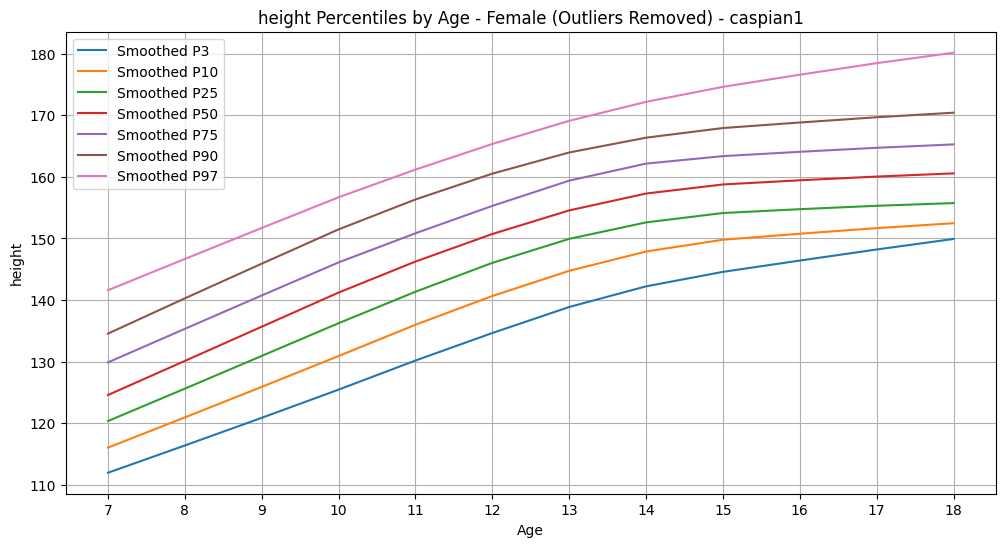

   Gender   Age      P3    P10    P25    P50    P75    P90     P97
12   Male   7.0  112.01  117.0  121.0  126.0  131.0  136.0  143.00
13   Male   8.0  117.00  121.0  125.0  130.0  135.0  140.0  146.00
14   Male   9.0  120.00  124.0  130.0  135.0  140.0  145.0  152.00
15   Male  10.0  124.00  129.0  134.0  139.0  145.0  150.0  155.00
16   Male  11.0  124.00  133.0  139.0  145.0  151.0  156.0  162.00
17   Male  12.0  134.00  140.0  146.0  151.0  158.0  164.0  170.00
18   Male  13.0  138.00  145.0  150.0  157.0  164.0  171.0  176.00
19   Male  14.0  143.00  150.0  157.0  164.0  170.0  175.0  180.00
20   Male  15.0  149.00  156.0  162.0  170.0  175.0  180.0  184.00
21   Male  16.0  154.00  160.0  165.0  172.0  177.0  181.0  186.00
22   Male  17.0  149.85  160.0  166.0  173.0  178.0  182.0  185.15
23   Male  18.0  155.61  160.0  166.0  173.0  178.0  183.0  185.39
[[  7.         112.10079795]
 [  8.         116.2613949 ]
 [  9.         120.48513828]
 [ 10.         124.74208662]
 [ 11.       

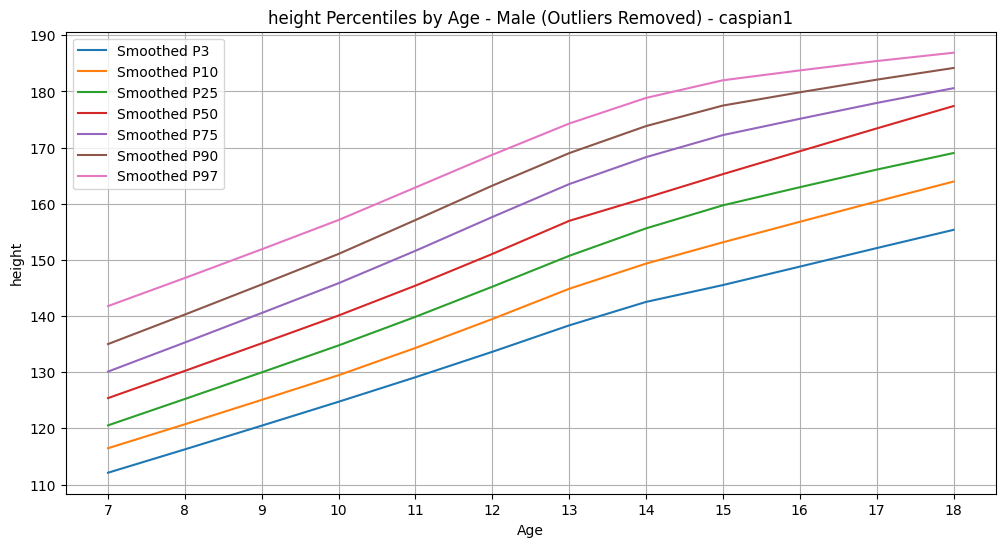

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Initialize an empty list to collect data for percentiles
percentile_data = []
frac = 0.7
percentile = [3,10, 25, 50, 75, 90,97]
percentiles_labels = ['P3', 'P10', 'P25', 'P50', 'P75','P90', 'P97']
features = ['height']


ages = sorted(grouped_with_z_score['age_x'].unique())
sexes = grouped_with_z_score['sex'].unique()

print(sexes)

#Loop through each feature to calculate the percentiles
for feature in features:
    for sex in sexes:
        for age in ages:
            height_data = grouped_with_z_score[(grouped_with_z_score['age_x'] == age) & (grouped_with_z_score['sex'] == sex)][f'{feature}']
            # Convert to numeric, coercing errors to NaN
            height_data = pd.to_numeric(height_data, errors='coerce')
            height_data = height_data.dropna()  # Remove NaN values

            # Check if there's enough data
            if height_data.size == 0:
                print(f"No valid data for sex: {sex}, age: {age}. Skipping...")
                continue  # Skip to the next iteration

            # Calculate the desired percentiles
            percentiles_values = np.percentile(height_data, percentile)
            # print(percentiles_values)
            
            # Collect data for this group
            percentile_data.append([sex, age] + percentiles_values.tolist())
            # print(percentile_data)
    # Create a DataFrame from the collected percentile data
    percentile_columns = ['Gender', 'Age'] + percentiles_labels
    percentile_df = pd.DataFrame(percentile_data, columns=percentile_columns)

    # Create separate plots for boys and girls
    for sex in sexes:
        fig, ax = plt.subplots(figsize=(12, 6))

        sex_data = percentile_df[percentile_df['Gender'] == sex]
        print(sex_data)
        for percentile_label in percentiles_labels:
            smoothed_percentile = lowess(sex_data[percentile_label], sex_data['Age'], frac=frac)
            print(smoothed_percentile)
            ax.plot(smoothed_percentile[:, 0], smoothed_percentile[:, 1], linestyle='-', label=f'Smoothed {percentile_label}')

        # Title and labels
        name = f'{feature} Percentiles by Age - {sex.capitalize()} (Outliers Removed) - caspian1'
        ax.set_title(f'{name}')
        ax.set_xlabel('Age')
        ax.set_ylabel(f'{feature}')
        ax.legend()
        plt.grid()
        plt.xticks(sex_data['Age'])
        plt.savefig(f'{name}.png')  # Save the plot with .png extension
        plt.show()
        plt.close()
        
    percentile_data.clear()


In [42]:
sex_data.columns

Index(['Gender', 'Age', 'P3', 'P10', 'P25', 'P50', 'P75', 'P90', 'P97'], dtype='object')

KeyError: 'Column not found: height'

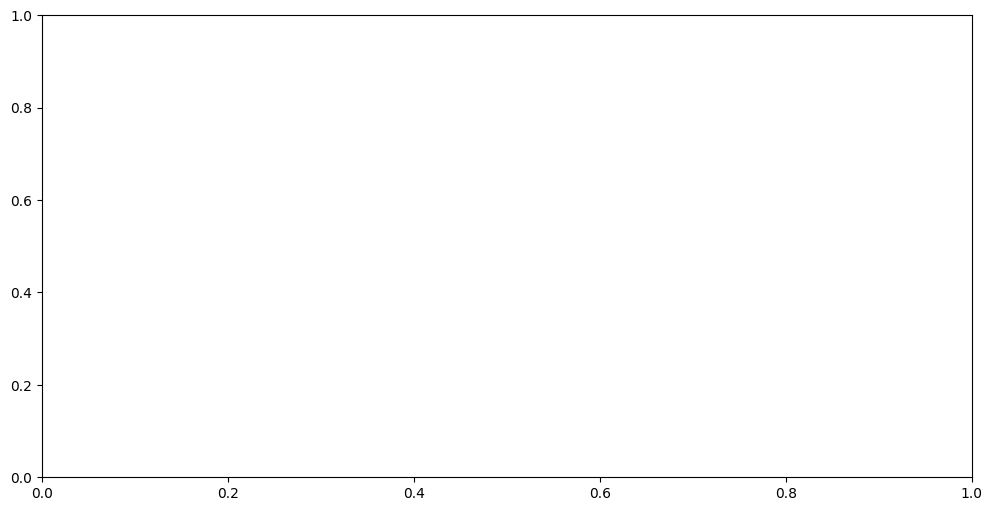

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Example dataset structure
# percentile_df should have columns: 'Age', 'Gender', 'Height'

z_scores = [-3, -2, -1, 0, 1, 2, 3]

for sex in sexes:
    fig, ax = plt.subplots(figsize=(12, 6))

    # Filter data for the current gender
    sex_data = percentile_df[percentile_df['Gender'] == sex]
    
    if sex_data.empty:
        print(f"No data available for gender: {sex}")
        continue  # Skip if no data for this gender
    
    # Calculate mean and standard deviation for each age group
    grouped_data = sex_data.groupby('Age')['height']
    means = grouped_data.mean()
    std_devs = grouped_data.std()

    for z in z_scores:
        # Calculate percentile values for this z-score
        percentile_values = means + (z * std_devs)
        
        # Apply LOESS smoothing
        smoothed_percentile = lowess(
            percentile_values.values, 
            means.index.values, 
            frac=0.2
        )
        
        # Plot smoothed percentiles
        ax.plot(
            smoothed_percentile[:, 0], 
            smoothed_percentile[:, 1], 
            linestyle='-', 
            label=f'Z={z}'
        )

    # Title and labels
    name = f'Growth Percentiles by Age - {sex.capitalize()} - Z-scores'
    ax.set_title(name)
    ax.set_xlabel('Age')
    ax.set_ylabel('Height')
    ax.legend()
    plt.grid()
    plt.xticks(means.index)
    
    # Save and show the plot
    plt.savefig(f'{name}.png')
    plt.show()
    plt.close()
